В этом ноутбуке считается косинусная схожесть между эмбеддингами картинок. Для генерации эмбеддингов используется предобученная модель ResNet18.

In [1]:
import json
import numpy as np
from tqdm.auto import tqdm
from numpy.linalg import norm
import pandas as pd; pd.set_option('max_columns', None)

### Считывание и предобработка данных

In [2]:
train = pd.read_csv('../data/train_with_features.csv')

train['clientid'] = train['clientid'].astype('uint32')
train['jointitemid'] = train['jointitemid'].astype('uint32')
train['label'] = train['label'].astype('int8')
train['novelty_cnt'] = train['novelty_cnt'].astype('int32')
train['count_on_session_view'] = train['count_on_session_view'].astype('int32')
train['count_on_session_tocart'] = train['count_on_session_tocart'].astype('int32')

train.shape

(1390438, 28)

In [3]:
test = pd.read_csv('../data/test_with_features.csv')

test['clientid'] = test['clientid'].astype('uint32')
test['jointitemid'] = test['jointitemid'].astype('uint32')
test['label'] = test['label'].astype('int8')
test['novelty_cnt'] = test['novelty_cnt'].astype('int32')
test['count_on_session_view'] = test['count_on_session_view'].astype('int32')
test['count_on_session_tocart'] = test['count_on_session_tocart'].astype('int32')

test.shape

(597158, 28)

### Генерация эмбеддингов

In [4]:
class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.get_feature_layer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
        
    def get_vec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def get_feature_layer(self):
        
        cnn_model = models.resnet18(pretrained=True)
        layer = cnn_model._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnn_model, layer

In [5]:
img2vec = Img2VecResnet18() 
all_vectors = {}

print("Converting images to feature vectors:")
for image in enumerate(tqdm(os.listdir('new_images'))):
    try:
        img = Image.open(os.path.join('new_iamges', image)).convert('RGB')
        vec = img2vec.get_vec(img)
        all_vectors[image] = vec
        img.close()
        
        if i % 50_000:
            with open('../data/vectors.json', 'w') as f:
                json.dump(all_vectors, f)
                
    except IOError:
        print('Filename not an image file')
        
with open('../data/image_vectors.json', 'w') as f:
    json.dump(all_vectors, f)

In [6]:
with open('../data/image_vectors.json', 'r') as f:
    vectors = json.load(f)

In [7]:
def similarity(x, y, vectors=vectors):
    if x in vectors and y in vectors:
        vec_1 = vectors[x]
        vec_2 = vectors[y]

        sim = np.inner(vec_1, vec_2) / (norm(vec_1) * norm(vec_2))
        
        return sim

### Косинусная схожесть по картинкам для train

In [8]:
train.loc[:, 'image_1'] = train['itemid'].astype('str') + '.jpg'
train.loc[:, 'image_2'] = train['jointitemid'].astype('str') + '.jpg'

In [9]:
train.loc[:, 'image_similarity'] = [
    similarity(x, y) for x, y in zip(train['image_1'],
                                     train['image_2'])
]

In [10]:
train.drop(['image_1', 'image_2'], axis=1, inplace=True)
print(train.shape)

train['image_similarity'] = train['image_similarity'].fillna(0)

(1390438, 29)


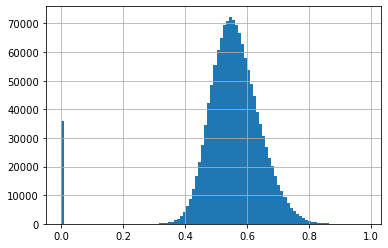

In [11]:
train['image_similarity'].hist(bins=100);

### Косинусная схожесть по картинкам для test

In [12]:
test.loc[:, 'image_1'] = test['itemid'].astype('str') + '.jpg'
test.loc[:, 'image_2'] = test['jointitemid'].astype('str') + '.jpg'

In [13]:
test.loc[:, 'image_similarity'] = [
    similarity(x, y) for x, y in zip(test['image_1'],
                                     test['image_2'])
]

In [14]:
test.drop(['image_1', 'image_2'], axis=1, inplace=True)
print(test.shape)

test['image_similarity'] = test['image_similarity'].fillna(0)

(597158, 29)


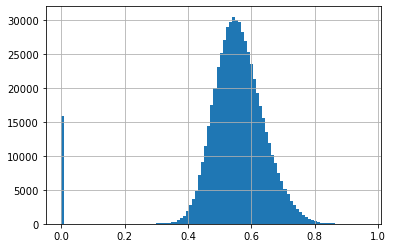

In [15]:
test['image_similarity'].hist(bins=100);

### Сохраняем принаки

In [16]:
train.to_csv('../data/train_with_all_features.csv', index=False)
test.to_csv('../data/test_with_all_features.csv', index=False)